In [1]:
from google.colab import files
files.upload()

{}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d itsahmad/indoor-scenes-cvpr-2019
!unzip -q indoor-scenes-cvpr-2019.zip -d indoor_scenes
!kaggle datasets download -d residentmario/ade20k-outdoors
!unzip -q ade20k-outdoors.zip -d outdoor_scenes


Dataset URL: https://www.kaggle.com/datasets/itsahmad/indoor-scenes-cvpr-2019
License(s): DbCL-1.0
 97% 2.28G/2.34G [00:19<00:01, 48.3MB/s]
100% 2.34G/2.34G [00:19<00:00, 130MB/s] 
Dataset URL: https://www.kaggle.com/datasets/residentmario/ade20k-outdoors
License(s): other
 58% 116M/200M [00:00<00:00, 1.21GB/s]
100% 200M/200M [00:01<00:00, 201MB/s] 


In [4]:
import os,shutil,glob
from sklearn.model_selection import train_test_split
base_dir="dataset"
for split in ["train","test"]:
  for cls in ["indoor","outdoor"]:
    os.makedirs(os.path.join(base_dir,split,cls),exist_ok=True)

indoor_path = "indoor_scenes/indoorCVPR_09/Images/*/*"
indoor_image = glob.glob(indoor_path)


outdoor_path = "outdoor_scenes/images/training/*"
outdoor_image = glob.glob(outdoor_path)


train_in,test_in = train_test_split(indoor_image,test_size=0.2,random_state=42)
train_out,test_out = train_test_split(outdoor_image,test_size=0.2,random_state=42)

def copy_files(file_list,target_folder):
  for f in file_list:
    try:
      shutil.copy(f,target_folder)
    except:
      pass

copy_files(train_in,os.path.join(base_dir,"train/indoor"))
copy_files(test_in,os.path.join(base_dir,"test/indoor"))
copy_files(train_out,os.path.join(base_dir,"train/outdoor"))
copy_files(test_out,os.path.join(base_dir,"test/outdoor"))


Using device: cuda
Classes: ['indoor', 'outdoor']
✅ Loaded saved model, skipping training.
🎯 Test Accuracy: 98.25242718446601 %


Saving images.jpg to images.jpg


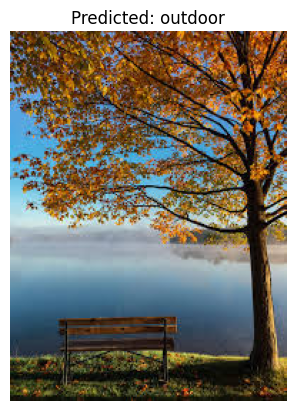

✅ Final Prediction: outdoor


In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder("dataset/train", transform=transform)
test_ds  = datasets.ImageFolder("dataset/test", transform=transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print("Classes:", train_ds.classes)

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_path = "indoor_outdoor_resnet18.pth"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("shafah trained model, skipping training.")
else:
    print(" Training model...")
    epochs = 5
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), model_path)
    print("Model trained & saved!")

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print("Test Accuracy:", 100 * correct / total, "%")


def upload_and_predict(model, transform, classes, device):
    uploaded = files.upload()
    img_path = list(uploaded.keys())[0]

    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_t)
        _, pred = torch.max(output, 1)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {classes[pred.item()]}")
    plt.show()

    print(" Final Prediction:", classes[pred.item()])

upload_and_predict(model, transform, train_ds.classes, device)
